In [1]:
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.filters import gaussian
import json
import os
import zarr
import mrcfile  # Import mrcfile to handle .mrc files
import re

In [2]:
def width_to_sigma(width, eps, lower_bound, upper_bound):
    # shrink needs to be between 0 and 1
    sigma = np.sqrt(-(width**2) / (2*np.log(eps)))
    #### bounding ####
    if lower_bound and upper_bound:
        if sigma < lower_bound:
            sigma = lower_bound
        elif sigma > upper_bound:
            sigma = upper_bound

    return int(sigma)

def create_gaussian_stamp(width, eps, lower_bound, upper_bound):
    """
    Creates a 3D Gaussian stamp (cube) with size width x width x width.
    If width is even, set width = width - 1.
    """
    if width % 2 == 0:
        width = width - 1
    
    sigma = width_to_sigma(width, eps, lower_bound, upper_bound)
    
    # Create a 3D matrix (stamp)
    stamp = np.zeros((width, width, width))
    center = width // 2
    
    # Set the center point to 1 (Gaussian peak)
    stamp[center, center, center] = 1

    # Apply 3D Gaussian filter to create the Gaussian distribution in 3D space
    #stamp = gaussian_filter(stamp, sigma=sigma)
    #Julia:
    stamp = gaussian(stamp, sigma=sigma, truncate=10.0, mode='constant')
    
    # Threshold the values based on epsilon and apply the scaling factor
    stamp[stamp < eps] = 0
    factor_3d = 2.5 #I had 1.6 as values for the centres of the gaussians before, but it should be 4, so 4/1.6=2.5
    stamp = stamp * 8 * factor_3d * np.pi * sigma**3

    return stamp
    
def parse_json_files(json_files):
    """
    Parse multiple JSON files to extract coordinates and protein names.

    Parameters:
        json_files (list of str): List of JSON file paths.

    Returns:
        list of tuples, list: Extracted coordinates and corresponding protein types.
    """
    coordinates = []
    protein_types = []

    for file in json_files:
        with open(file, 'r') as f:
            data = json.load(f)

            points = data.get("points", [])
            for point in points:
                location = point.get("location", {})
                x = location.get("x")
                y = location.get("y")
                z = location.get("z")
                if x is not None and y is not None and z is not None:
                    coordinates.append((z / 10, y / 10, x / 10))  # Scale coordinates as needed
                    protein_types.append(data.get("pickable_object_name", "unknown"))

    return coordinates, protein_types

def create_width_dict():
    """
    Create a dictionary mapping protein names to widths.

    Returns:
        dict: Protein name to width mapping.
    """
    # Define protein lists
    PROTEINS_LIST = [
        "in_10A/4v4r_10A.pns",
        "in_10A/3j9i_10A.pns",
        "in_10A/4v4r_50S_10A.pns",
        "in_10A/4v4r_30S_10A.pns",
        "in_10A/6utj_10A.pns",
        "in_10A/5mrc_10A.pns",
        "in_10A/4v7r_10A.pns",
        "in_10A/2uv8_10A.pns",
        "in_10A/4v94_10A.pns",
        "in_10A/4cr2_10A.pns",
        "in_10A/3qm1_10A.pns",
        "in_10A/3h84_10A.pns",
        "in_10A/3gl1_10A.pns",
        "in_10A/3d2f_10A.pns",
        "in_10A/3cf3_10A.pns",
        "in_10A/2cg9_10A.pns",
        "in_10A/1u6g_10A.pns",
        "in_10A/1s3x_10A.pns",
        "in_10A/1qvr_10A.pns",
        "in_10A/1bxn_10A.pns",
    ]

    MB_PROTEINS_LIST = [
        "in_10A/mb_6rd4_10A.pms",
        "in_10A/mb_5wek_10A.pms",
        "in_10A/mb_4pe5_10A.pms",
        "in_10A/mb_5ide_10A.pms",
        "in_10A/mb_5gjv_10A.pms",
        "in_10A/mb_5kxi_10A.pms",
        "in_10A/mb_5tj6_10A.pms",
        "in_10A/mb_5tqq_10A.pms",
        "in_10A/mb_5vai_10A.pms",
    ]

    # Combine both lists
    ALL_PROTEINS = PROTEINS_LIST + MB_PROTEINS_LIST

    def extract_mrc_path(protein_file):
        """Extracts MMER_SVOL path from a .pns or .pms file."""
        try:
            with open(protein_file, "r") as f:
                for line in f:
                    match = re.search(r"MMER_SVOL\s*=\s*(\S+)", line)
                    if match:
                        return match.group(1)  # Return the MRC file path
        except FileNotFoundError:
            print(f"File not found: {protein_file}")
        return None

    def get_mrc_dimensions(mrc_path):
        """Extracts the dimensions of a protein from an MRC file."""
        try:
            with mrcfile.open(mrc_path, permissive=True) as mrc:
                voxel_size = mrc.voxel_size.x  # Assuming isotropic voxels
                data_shape = mrc.data.shape  # (z, y, x)
                dimensions = [s * voxel_size for s in data_shape[::-1]]  # Convert to (x, y, z)
                return max(dimensions)/10 # Return the largest dimension as the width
        except Exception as e:
            print(f"Error processing {mrc_path}: {e}")
            return None

    # Dictionary to store protein names and their widths
    protein_widths = {}
    root_dir = "/Users/yusufberkoruc/Desktop/Master_thesis/polnet/data"

    for protein_file in ALL_PROTEINS:
        # Construct the full path to the protein file
        protein_file_full_path = os.path.join(root_dir, protein_file)
        
        # Extract the MRC file path
        mrc_path = extract_mrc_path(protein_file_full_path)
        
        if mrc_path:
            # Construct the full path to the MRC file
            mrc_path_full = os.path.join(root_dir, mrc_path.lstrip("/"))
            
            if os.path.exists(mrc_path_full):
                # Calculate the width (largest dimension)
                width = get_mrc_dimensions(mrc_path_full)
                
                if width:
                    # Extract the protein name (e.g., mb_5gjv_10A)
                    protein_name = os.path.basename(protein_file).replace(".pns", "").replace(".pms", "")
                    
                    # Add to the dictionary
                    protein_widths[protein_name] = width
                else:
                    print(f"Could not determine width for {protein_file}")
            else:
                print(f"MRC file not found: {mrc_path_full}")
        else:
            print(f"No MMER_SVOL found in {protein_file}")
    return protein_widths


def precompute_gaussians(width_dict, eps, lower_bound, upper_bound):
    return {protein: create_gaussian_stamp(int(width * 0.3), eps, lower_bound, upper_bound) for protein, width in width_dict.items()}

def get_tomo_shape(file_path):
    """
    Get the shape of a tomogram stored in either a Zarr or MRC file.
    
    Parameters:
        file_path (str): Path to the file (either .zarr or .mrc).
    
    Returns:
        tuple: Shape of the tomogram, or None if not found.
    """
    if file_path.endswith(".zarr"):
        zarr_store = zarr.open(file_path, mode='r')
        return zarr_store["0"].shape if "0" in zarr_store else None

    elif file_path.endswith(".mrc"):
        with mrcfile.open(file_path, mode="r") as mrc:
            return mrc.data.shape  # MRC files store data as (Z, Y, X)


    return None  # Unsupported file format

In [3]:
def create_heatmap(json_folder, image_shape, eps=0.00001, sigma=None, lower_bound=None, upper_bound=None, bb=None):
    """
    Process a tomogram by creating a heatmap based on protein data from JSON files,
    with optional bounding box constraints.

    Parameters:
        json_folder (str): Path to the folder containing JSON files.
        image_shape (tuple): Shape of the 3D image (z, y, x).
        eps (float): Threshold for truncating the Gaussian.
        sigma (float, optional): Fixed sigma value for Gaussian.
        lower_bound (float, optional): Minimum allowed sigma.
        upper_bound (float, optional): Maximum allowed sigma.
        bb (tuple, optional): Bounding box (z_min, z_max, y_min, y_max, x_min, x_max).

    Returns:
        np.ndarray: Generated 3D heatmap.
    """
    picks_folder = os.path.join(json_folder, "Picks")
    json_files = [os.path.join(picks_folder, f) for f in os.listdir(picks_folder) if f.endswith('.json')]
    coordinates, protein_types = parse_json_files(json_files)
    width_dict = create_width_dict()
    gaussian_dict = precompute_gaussians(width_dict, eps, lower_bound, upper_bound)
    
    if bb:
        (z_min, z_max), (y_min, y_max), (x_min, x_max) = [(s.start, s.stop) for s in bb]
        restricted_shape = (z_max - z_min, y_max - y_min, x_max - x_min)
        heatmap = np.zeros(restricted_shape)
    else:
        heatmap = np.zeros(image_shape)
    
    for coord, protein in zip(coordinates, protein_types):
        z, y, x = map(int, coord)
        gaussian = gaussian_dict.get(protein, create_gaussian_stamp(1, eps, lower_bound, upper_bound))
        
        if bb and not (z_min <= z < z_max and y_min <= y < y_max and x_min <= x < x_max):
            continue
        
        z_offset, y_offset, x_offset = (z_min, y_min, x_min) if bb else (0, 0, 0)
        z, y, x = z - z_offset, y - y_offset, x - x_offset
        
        z_min_hm = max(0, z - gaussian.shape[0] // 2)
        z_max_hm = min(heatmap.shape[0], z + gaussian.shape[0] // 2 + 1)
        y_min_hm = max(0, y - gaussian.shape[1] // 2)
        y_max_hm = min(heatmap.shape[1], y + gaussian.shape[1] // 2 + 1)
        x_min_hm = max(0, x - gaussian.shape[2] // 2)
        x_max_hm = min(heatmap.shape[2], x + gaussian.shape[2] // 2 + 1)
        
        heatmap[z_min_hm:z_max_hm, y_min_hm:y_max_hm, x_min_hm:x_max_hm] = np.maximum(
            heatmap[z_min_hm:z_max_hm, y_min_hm:y_max_hm, x_min_hm:x_max_hm],
            gaussian[
                (z_min_hm - (z - gaussian.shape[0] // 2)):(z_max_hm - (z - gaussian.shape[0] // 2)),
                (y_min_hm - (y - gaussian.shape[1] // 2)):(y_max_hm - (y - gaussian.shape[1] // 2)),
                (x_min_hm - (x - gaussian.shape[2] // 2)):(x_max_hm - (x - gaussian.shape[2] // 2))
            ]
        )
    
    return heatmap

def create_heatmap_debug(json_folder, image_shape, eps=0.00001, sigma=None, lower_bound=None, upper_bound=None, bb=None):
    """
    Process a tomogram by creating a heatmap based on protein data from JSON files,
    with optional bounding box constraints.

    Parameters:
        json_folder (str): Path to the folder containing JSON files.
        image_shape (tuple): Shape of the 3D image (z, y, x).
        eps (float): Threshold for truncating the Gaussian.
        sigma (float, optional): Fixed sigma value for Gaussian.
        lower_bound (float, optional): Minimum allowed sigma.
        upper_bound (float, optional): Maximum allowed sigma.
        bb (tuple, optional): Bounding box (z_min, z_max, y_min, y_max, x_min, x_max).

    Returns:
        np.ndarray: Generated 3D heatmap.
    """
    print(f"Starting create_heatmap with image_shape: {image_shape}, eps: {eps}, sigma: {sigma}, bb: {bb}")

    picks_folder = os.path.join(json_folder, "Picks")
    json_files = [os.path.join(picks_folder, f) for f in os.listdir(picks_folder) if f.endswith('.json')]
    print(f"Found {len(json_files)} JSON files in {picks_folder}")

    coordinates, protein_types = parse_json_files(json_files)
    print(f"Parsed {len(coordinates)} coordinates and {len(protein_types)} protein types")

    width_dict = create_width_dict()
    print(f"Created width dictionary with {len(width_dict)} entries")

    gaussian_dict = precompute_gaussians(width_dict, eps, lower_bound, upper_bound)
    print(f"Precomputed {len(gaussian_dict)} Gaussian stamps")

    if bb:
        (z_min, z_max), (y_min, y_max), (x_min, x_max) = [(s.start, s.stop) for s in bb]
        restricted_shape = (z_max - z_min, y_max - y_min, x_max - x_min)
        heatmap = np.zeros(restricted_shape)
        print(f"Using bounding box with restricted shape: {restricted_shape}")
    else:
        heatmap = np.zeros(image_shape)
        print(f"Using full image shape for heatmap: {image_shape}")

    for i, (coord, protein) in enumerate(zip(coordinates, protein_types)):
        z, y, x = map(int, coord)
        gaussian = gaussian_dict.get(protein, create_gaussian_stamp(1, eps, lower_bound, upper_bound))

        if bb and not (z_min <= z < z_max and y_min <= y < y_max and x_min <= x < x_max):
            print(f"Skipping coordinate {coord} as it is outside the bounding box")
            continue

        z_offset, y_offset, x_offset = (z_min, y_min, x_min) if bb else (0, 0, 0)
        z, y, x = z - z_offset, y - y_offset, x - x_offset

        z_min_hm = max(0, z - gaussian.shape[0] // 2)
        z_max_hm = min(heatmap.shape[0], z + gaussian.shape[0] // 2 + 1)
        y_min_hm = max(0, y - gaussian.shape[1] // 2)
        y_max_hm = min(heatmap.shape[1], y + gaussian.shape[1] // 2 + 1)
        x_min_hm = max(0, x - gaussian.shape[2] // 2)
        x_max_hm = min(heatmap.shape[2], x + gaussian.shape[2] // 2 + 1)

        # Debugging statements for ranges
        print(f"Processing coordinate {coord} for protein {protein}")
        print(f"Gaussian shape: {gaussian.shape}")
        print(f"Heatmap ranges: z[{z_min_hm}:{z_max_hm}], y[{y_min_hm}:{y_max_hm}], x[{x_min_hm}:{x_max_hm}]")

        # Ensure valid ranges
        if z_min_hm >= z_max_hm or y_min_hm >= y_max_hm or x_min_hm >= x_max_hm:
            print(f"Invalid ranges for coordinate {coord}, skipping")
            continue

        heatmap[z_min_hm:z_max_hm, y_min_hm:y_max_hm, x_min_hm:x_max_hm] = np.maximum(
            heatmap[z_min_hm:z_max_hm, y_min_hm:y_max_hm, x_min_hm:x_max_hm],
            gaussian[
                (z_min_hm - (z - gaussian.shape[0] // 2)):(z_max_hm - (z - gaussian.shape[0] // 2)),
                (y_min_hm - (y - gaussian.shape[1] // 2)):(y_max_hm - (y - gaussian.shape[1] // 2)),
                (x_min_hm - (x - gaussian.shape[2] // 2)):(x_max_hm - (x - gaussian.shape[2] // 2))
            ]
        )

    print("Finished creating heatmap")
    return heatmap

def create_heatmap_edited(json_folder, image_shape, eps=0.00001, sigma=None, lower_bound=None, upper_bound=None, bb=None):
    """
    Process a tomogram by creating a heatmap based on protein data from JSON files,
    with optional bounding box constraints.

    Parameters:
        json_folder (str): Path to the folder containing JSON files.
        image_shape (tuple): Shape of the 3D image (z, y, x).
        eps (float): Threshold for truncating the Gaussian.
        sigma (float, optional): Fixed sigma value for Gaussian.
        lower_bound (float, optional): Minimum allowed sigma.
        upper_bound (float, optional): Maximum allowed sigma.
        bb (tuple, optional): Bounding box (z_min, z_max, y_min, y_max, x_min, x_max).

    Returns:
        np.ndarray: Generated 3D heatmap.
    """
    picks_folder = os.path.join(json_folder, "Picks")
    json_files = [os.path.join(picks_folder, f) for f in os.listdir(picks_folder) if f.endswith('.json')]
    coordinates, protein_types = parse_json_files(json_files)
    width_dict = create_width_dict()
    gaussian_dict = precompute_gaussians(width_dict, eps, lower_bound, upper_bound)
    
    if bb:
        (z_min, z_max), (y_min, y_max), (x_min, x_max) = [(s.start, s.stop) for s in bb]
        restricted_shape = (z_max - z_min, y_max - y_min, x_max - x_min)
        heatmap = np.zeros(restricted_shape)
    else:
        heatmap = np.zeros(image_shape)
    
    for coord, protein in zip(coordinates, protein_types):
        z, y, x = map(int, coord)
        gaussian = gaussian_dict.get(protein, create_gaussian_stamp(1, eps, lower_bound, upper_bound))
        
        if bb and not (z_min <= z < z_max and y_min <= y < y_max and x_min <= x < x_max):
            continue
        
        z_offset, y_offset, x_offset = (z_min, y_min, x_min) if bb else (0, 0, 0)
        z, y, x = z - z_offset, y - y_offset, x - x_offset
        
        z_min_hm = max(0, z - gaussian.shape[0] // 2)
        z_max_hm = min(heatmap.shape[0], z + gaussian.shape[0] // 2 + 1)
        y_min_hm = max(0, y - gaussian.shape[1] // 2)
        y_max_hm = min(heatmap.shape[1], y + gaussian.shape[1] // 2 + 1)
        x_min_hm = max(0, x - gaussian.shape[2] // 2)
        x_max_hm = min(heatmap.shape[2], x + gaussian.shape[2] // 2 + 1)
        
        # Ensure valid ranges
        if z_min_hm >= z_max_hm or y_min_hm >= y_max_hm or x_min_hm >= x_max_hm:
            continue
        
        # Debugging print statements
        print(f"z_min_hm: {z_min_hm}, z_max_hm: {z_max_hm}")
        print(f"y_min_hm: {y_min_hm}, y_max_hm: {y_max_hm}")
        print(f"x_min_hm: {x_min_hm}, x_max_hm: {x_max_hm}")
        print(f"heatmap shape: {heatmap.shape}")
        print(f"gaussian shape: {gaussian.shape}")

        heatmap[z_min_hm:z_max_hm, y_min_hm:y_max_hm, x_min_hm:x_max_hm] = np.maximum(
            heatmap[z_min_hm:z_max_hm, y_min_hm:y_max_hm, x_min_hm:x_max_hm],
            gaussian[
                (z_min_hm - (z - gaussian.shape[0] // 2)):(z_max_hm - (z - gaussian.shape[0] // 2)),
                (y_min_hm - (y - gaussian.shape[1] // 2)):(y_max_hm - (y - gaussian.shape[1] // 2)),
                (x_min_hm - (x - gaussian.shape[2] // 2)):(x_max_hm - (x - gaussian.shape[2] // 2))
            ]
        )
    
    return heatmap

In [4]:


def get_label(json_folder, image_shape, eps=0.00001, sigma=None, lower_bound=None, upper_bound=None, bb=None):

    have_single_file = isinstance(json_folder, str)

    if have_single_file:
        print("it is a single file")
        return create_heatmap(json_folder, image_shape, eps, sigma, lower_bound, upper_bound, bb)
    else:
        print(f"len json folder {len(json_folder)}")
        return np.stack([create_heatmap(p, image_shape, eps, sigma, lower_bound, upper_bound, bb) for p in json_folder])






In [5]:
def main(file_path=None, json_folder=None, output_folder=None):
    
    tomogram_shape = get_tomo_shape(file_path)
    if tomogram_shape is not None:
        os.makedirs(output_folder, exist_ok=True)
        tomogram_index = 0
        output_file =  os.path.join(output_folder, f"{tomogram_index}_heatmap.npy")

        heatmap =get_label(json_folder, tomogram_shape)

        # Save the heatmap to a file
        np.save(output_file, heatmap)
        print(f"Heatmap saved to {output_file}")

    else:
        print("No 0 zarr was found")
        print("No tomogram shape found. Please check the file path or format.")




In [6]:
file_path = "/Users/yusufberkoruc/Desktop/Master_thesis/polnet/train/static/ExperimentRuns/tomogram_0_0/tomo_rec_0_snr1.44.mrc"
json_folder = "/Users/yusufberkoruc/Desktop/Master_thesis/polnet/train/overlay/ExperimentRuns/tomogram_0_0"
output_folder = "/Users/yusufberkoruc/Desktop/Master_thesis/polnet/heat_map_output"
   
if __name__ == "__main__":
    main(file_path=file_path, json_folder=json_folder, output_folder=output_folder)

it is a single file
Heatmap saved to /Users/yusufberkoruc/Desktop/Master_thesis/polnet/heat_map_output/0_heatmap.npy


Peak value: 3.9894228040143282 at (np.int64(6), np.int64(167), np.int64(352))


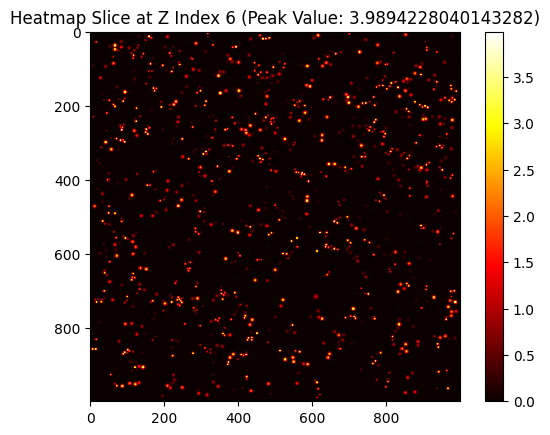

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import mrcfile
import napari

# File paths
heatmap_file = os.path.join(output_folder, "0_heatmap.npy")
mrc_file = file_path
gt_file = "/Users/yusufberkoruc/Desktop/Master_thesis/polnet/data_simulated/all_v1/tomos/tomo_lbls_0.mrc"
# Load the heatmap
heatmap = np.load(heatmap_file)

# Load the tomogram (ground truth) from the .mrc file
with mrcfile.open(mrc_file, permissive=True) as mrc:
    tomogram = mrc.data
# Load the tomogram (ground truth) from the .mrc file
with mrcfile.open(gt_file, permissive=True) as gt:
    ground_truth = gt.data
# Ensure both arrays have the same shape (if necessary, resize/interpolate heatmap)
if heatmap.shape != tomogram.shape:
    print(f"Warning: Shape mismatch! Heatmap: {heatmap.shape}, Tomogram: {tomogram.shape}")

# Find the peak value in the heatmap
peak_value = np.max(heatmap)
peak_coords = np.unravel_index(np.argmax(heatmap), heatmap.shape)
print(f"Peak value: {peak_value} at {peak_coords}")

# Visualize the slice containing the peak value using matplotlib
z, y, x = peak_coords
plt.imshow(heatmap[z], cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title(f"Heatmap Slice at Z Index {z} (Peak Value: {peak_value})")
plt.show()

# Open in Napari
viewer = napari.Viewer()

# Add the tomogram (ground truth) first
viewer.add_image(tomogram, name="Tomogram", colormap="gray", blending="additive")

# Add the heatmap on top
viewer.add_image(heatmap, name="Heatmap", colormap="red", opacity=0.5, blending="additive")

viewer.add_image(ground_truth, name="Ground_truth", colormap="gray", opacity=0.5, blending="additive")


# Highlight the peak value
viewer.add_points([peak_coords], size=10, face_color="red", name="Peak")

# Start Napari
napari.run()
